In [10]:
import sys 
import os 

sys.path.append('../..')

DATA_DIR = '../../data'
os.environ['DATA_DIR'] = DATA_DIR

from utils.correlation import calc_correlation, vectorize_concepts
from utils.data import load_data, load_gpt, load_cslb, load_sorting, load_cslb_count_vec, load_mcrae, generate_concepts_to_keep, match_behv_sim, load_behav
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from nltk import ngrams
nlp = spacy.load("en_core_web_sm")




In [8]:
gpt_df, mc_df, behv_sim_all, cslb_df, sorting_df, bert_df = load_data(True, True, 4, 1, None, True, 1, True)

cslb_df = cslb_df.rename(columns={'feature': 'true_feature'})
gpt_df = gpt_df.rename(columns={'feature': 'pred_feature'})

../../data


/home/hannes/anaconda3/envs/features/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# How many human created features are covered? 

In [24]:
merged_df = gpt_df.merge(cslb_df, on='concept_id')

def calc_sim(row):
    test_features_splitted = row.true_feature.split(';')
    pred_features_splitted = row.pred_feature.split(';')
    count = 0
    for true_feature in test_features_splitted:
        if true_feature in pred_features_splitted:
            count += 1

    coverage = count / len(test_features_splitted) * 100
    return coverage

merged_df['coverage_feature'] = merged_df.apply(calc_sim, axis=1)
merged_df['coverage_feature'].describe()

count    451.000000
mean      26.208215
std        8.966586
min        0.000000
25%       20.000000
50%       26.315789
75%       32.101695
max       56.097561
Name: coverage_feature, dtype: float64

# How man ngrams are covered ?

In [14]:
[b for b in ngrams('sdsdsd', n=4)]

[('s', 'd', 's', 'd'), ('d', 's', 'd', 's'), ('s', 'd', 's', 'd')]

In [25]:
n_ngrams = 4

def calc_sim(row):
    test_features_splitted = row.true_feature.split(',')
    test_set = set()
    pred_set = set()
    for test_feature in test_features_splitted:
        for ngram in ngrams(test_feature, n_ngrams):
            test_set.add(ngram)

    pred_features_splitted = row.pred_feature.split(',')
    for pred_feature in pred_features_splitted:
        for ngram in ngrams(pred_feature, n_ngrams):
            pred_set.add(ngram)
            
    count = 0
    for true_feature_gram in test_set:
        if true_feature_gram in pred_set:
            count += 1

    coverage = count / len(test_set) * 100
    return coverage

merged_df['coverage_ngram'] = merged_df.apply(calc_sim, axis=1)
merged_df['coverage_ngram'].describe()

count    451.000000
mean      50.055568
std        6.683371
min       23.122530
25%       45.731050
50%       49.797571
75%       54.730753
max       72.025723
Name: coverage_ngram, dtype: float64

In [32]:
merged_df = merged_df[['coverage_feature', 'coverage_ngram']]
merged_df = merged_df.rename(columns={'coverage_feature': 'Per feature', 'coverage_ngram': 'Per 4-gram'})

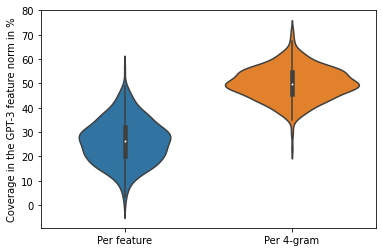

In [34]:
sns.violinplot(data=merged_df, show_mean=True)
plt.ylabel('Coverage in the GPT-3 feature norm in %')
plt.savefig('coverage.svg')